<a href="https://colab.research.google.com/github/vinismachadoo/aviacao_civil_brasil/blob/main/controle_estatistico_voos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download -d ramirobentes/flights-in-brazil

flights-in-brazil.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip flights-in-brazil.zip

Archive:  flights-in-brazil.zip
replace BrFlights2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BrFlights2.csv          
replace BrFlights2/BrFlights2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BrFlights2/BrFlights2.csv  


In [5]:
!pip install geopandas --quiet

In [6]:
import pandas as pd
pd.options.display.max_columns=100

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import geopandas as gpd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
mapa_brasil = gpd.read_file('https://raw.githubusercontent.com/vinismachadoo/aviacao_civil_brasil/main/uf_brasil.geojson')

In [8]:
voos_brasil = pd.read_csv('BrFlights2.csv', encoding='ISO-8859-1')

In [9]:
#Escolhemos trabalhar apenas com voos regionais e nacionais, portanto deletando quaisquer origem ou destino internacional
voos_brasil = voos_brasil[~voos_brasil['Codigo.Tipo.Linha'].isin(['Internacional'])]

In [10]:
voos_brasil.shape

(2221559, 21)

In [11]:
voos_brasil.head()

,Voos,Companhia.Aerea,Codigo.Tipo.Linha,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Cidade.Origem,Estado.Origem,Pais.Origem,Aeroporto.Destino,Cidade.Destino,Estado.Destino,Pais.Destino,LongDest,LatDest,LongOrig,LatOrig
2659,AZU - 2400,AZUL,Regional,2016-01-18T08:25:00Z,NaN,2016-01-18T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2660,AZU - 2400,AZUL,Regional,2016-01-26T08:25:00Z,NaN,2016-01-26T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2661,AZU - 2400,AZUL,Regional,2016-01-22T08:25:00Z,NaN,2016-01-22T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2662,AZU - 2400,AZUL,Regional,2016-01-16T08:25:00Z,NaN,2016-01-16T09:32:00Z,NaN,Cancelado,CANCELAMENTO - AEROPORTO DESTINO ABAIXO LIMITES,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553
2663,AZU - 2400,AZUL,Regional,2016-01-01T08:25:00Z,NaN,2016-01-01T09:32:00Z,NaN,Cancelado,AUTORIZADO,Guarulhos - Governador Andre Franco Montoro,Guarulhos,SP,Brasil,Santos Dumont,Rio De Janeiro,RJ,Brasil,-43.164876,-22.911144,-46.478126,-23.434553


In [12]:
#Acertando as colunas com dia e hora para formato datetime
voos_brasil['Partida.Prevista'] = pd.to_datetime(voos_brasil['Partida.Prevista'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Partida.Real'] = pd.to_datetime(voos_brasil['Partida.Real'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Chegada.Prevista'] = pd.to_datetime(voos_brasil['Chegada.Prevista'], format="%Y-%m-%dT%H:%M:%SZ")
voos_brasil['Chegada.Real'] = pd.to_datetime(voos_brasil['Chegada.Real'], format="%Y-%m-%dT%H:%M:%SZ")

In [13]:
#Novas colunas apenas com data
voos_brasil['Partida.Prevista.Data'] = voos_brasil['Partida.Prevista'].dt.date
voos_brasil['Partida.Real.Data'] = voos_brasil['Partida.Real'].dt.date
voos_brasil['Chegada.Prevista.Data'] = voos_brasil['Chegada.Prevista'].dt.date
voos_brasil['Chegada.Real.Data'] = voos_brasil['Chegada.Real'].dt.date

In [14]:
f"Primeiro dia do dataset: {voos_brasil['Partida.Prevista.Data'].min()}. Ultimo dia do dataset: {voos_brasil['Partida.Prevista.Data'].max()}"

'Primeiro dia do dataset: 2015-01-01. Ultimo dia do dataset: 2017-08-01'

In [15]:
voos_brasil_2015 = voos_brasil[voos_brasil['Partida.Prevista'].dt.year == 2015]
voos_brasil_2015['Mes.Dia'] = voos_brasil_2015['Partida.Prevista'].dt.month.astype(str) + '-' + voos_brasil_2015['Partida.Prevista'].dt.day.astype(str)
voos_brasil_2016 = voos_brasil[voos_brasil['Partida.Prevista'].dt.year == 2016]
voos_brasil_2016['Mes.Dia'] = voos_brasil_2016['Partida.Prevista'].dt.month.astype(str) + '-' + voos_brasil_2016['Partida.Prevista'].dt.day.astype(str)
voos_brasil_2017 = voos_brasil[voos_brasil['Partida.Prevista'].dt.year == 2017]
voos_brasil_2017['Mes.Dia'] = voos_brasil_2017['Partida.Prevista'].dt.month.astype(str) + '-' + voos_brasil_2017['Partida.Prevista'].dt.day.astype(str)

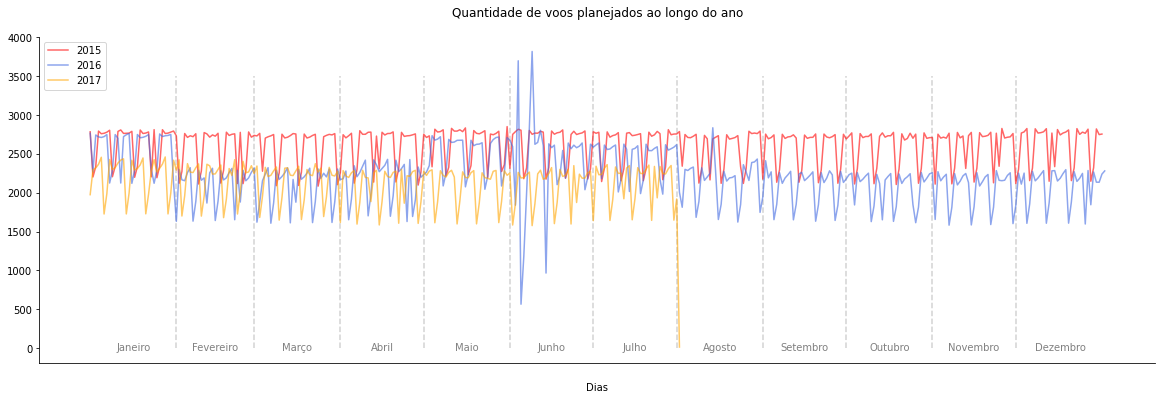

In [16]:
fig,ax = plt.subplots(figsize=(20,6))
voos_brasil_2015.groupby('Mes.Dia')['Voos'].count().plot(label='2015', color='red', alpha=0.6)
voos_brasil_2016.groupby('Mes.Dia')['Voos'].count().plot(label='2016', color='royalblue', alpha=0.6)
voos_brasil_2017.groupby('Mes.Dia')['Voos'].count().plot(label='2017', color='orange', alpha=0.6)

plt.title('Quantidade de voos planejados ao longo do ano', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Dias', labelpad=20)

meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro']
primeiro_dia_mes = [0,31,59,90,120,151,181,211,242,272,303,333]
for i in range(11):
  ax.vlines(x=primeiro_dia_mes[i+1],ymin=0,ymax=3500, color='lightgray', linestyle='--')
  ax.text((primeiro_dia_mes[i]+primeiro_dia_mes[i+1])/2, 10, meses[i], ha='center', va='center', color='gray')
ax.text(349,10,"Dezembro", ha='center', va='center', color='gray')
plt.xticks([])

plt.legend(loc='upper left')
plt.show()

In [17]:
#Novas colunas com o dia da semana do voo
voos_brasil['Partida.Prevista.Dia.Semana'] = voos_brasil['Partida.Prevista'].dt.day_name()
voos_brasil['Partida.Real.Dia.Semana'] = voos_brasil['Partida.Real'].dt.day_name()
voos_brasil['Chegada.Prevista.Dia.Semana'] = voos_brasil['Chegada.Prevista'].dt.day_name()
voos_brasil['Chegada.Real.Dia.Semana'] = voos_brasil['Chegada.Real'].dt.day_name()

In [18]:
#Dissecando o status 'Realizado' em 3: 'Atrasado', 'Adiantado' ou 'Em ponto'
voos_brasil.loc[voos_brasil['Partida.Real'] > voos_brasil['Partida.Prevista'], 'Situacao.Voo'] = 'Atrasado'
voos_brasil.loc[voos_brasil['Partida.Real'] < voos_brasil['Partida.Prevista'], 'Situacao.Voo'] = 'Adiantado'
voos_brasil['Situacao.Voo'].replace({'Realizado': 'Em ponto'}, inplace=True)

In [19]:
voos_brasil['Situacao.Voo'].value_counts()

Em ponto     1284055
Adiantado     351045
Atrasado      311179
Cancelado     275280
Name: Situacao.Voo, dtype: int64

In [20]:
#Agrupando por dia da semana e status do voo
situacao_por_dia_semana = voos_brasil.groupby(['Partida.Prevista.Dia.Semana'])['Situacao.Voo'].value_counts().unstack().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [21]:
situacao_por_dia_semana

Situacao.Voo,Adiantado,Atrasado,Cancelado,Em ponto
Partida.Prevista.Dia.Semana,,,,
Monday,54037,50515,39389,198265
Tuesday,53950,42607,43186,189861
Wednesday,53753,45220,42680,190972
Thursday,51608,53002,40419,192276
Friday,50503,57062,40822,195760
Saturday,40212,29436,35777,149728
Sunday,46982,33337,33007,167193


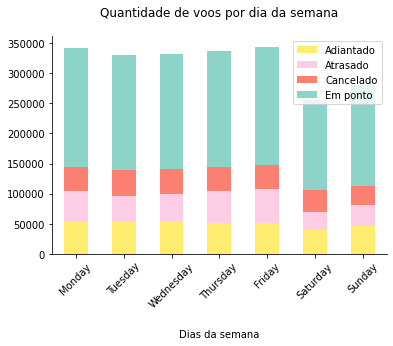

In [22]:
situacao_por_dia_semana.plot(kind='bar', stacked=True, colormap='Set3_r')
plt.title('Quantidade de voos por dia da semana', pad=20, fontsize=12, color='black')
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dias da semana', labelpad=20)
plt.legend(loc='upper right')
plt.show()

In [23]:
#Quantidade de voos por companhia dividido por status do voo
situacao_por_companhia = voos_brasil.groupby(['Companhia.Aerea'])['Situacao.Voo'].value_counts().unstack()
situacao_por_companhia = situacao_por_companhia.assign(tmp=situacao_por_companhia.sum(axis=1)).sort_values('tmp', ascending=True).drop('tmp', 1)

In [24]:
situacao_por_companhia

Situacao.Voo,Adiantado,Atrasado,Cancelado,Em ponto
Companhia.Aerea,,,,
TRIP,NaN,NaN,NaN,10.0
TOTAL,599.0,697.0,16.0,3.0
FLYWAYS,30.0,151.0,473.0,1352.0
SETE,224.0,1693.0,511.0,5292.0
MAP LINHAS AEREAS,1940.0,1516.0,666.0,11553.0
PASSAREDO,2845.0,16537.0,12331.0,38723.0
AVIANCA BRASIL,9267.0,31835.0,5995.0,136282.0
TAM,20222.0,68413.0,39589.0,357192.0
GOL,13265.0,86542.0,109850.0,510733.0


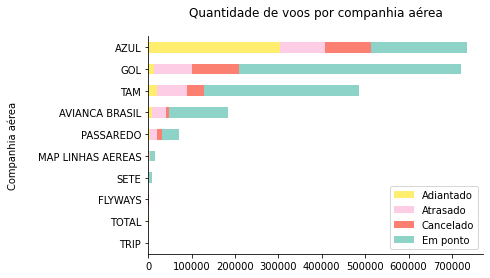

In [25]:
situacao_por_companhia.plot(kind='barh', stacked=True, colormap='Set3_r')
plt.title('Quantidade de voos por companhia aérea', pad=20, fontsize=12, color='black')
sns.despine()
plt.ylabel('Companhia aérea', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [26]:
#Usaremos só as 4 maiores companhias nacionais pois as demais não apresentam relevância
voos_brasil = voos_brasil[voos_brasil['Companhia.Aerea'].isin(['AZUL','GOL','TAM','AVIANCA BRASIL'])]

In [27]:
#10 maiores aeroportos por quantidade absoluta de voo
situacao_por_aeroporto_origem = voos_brasil.groupby(['Aeroporto.Origem'])['Situacao.Voo'].value_counts().unstack()
situacao_por_aeroporto_origem = situacao_por_aeroporto_origem.assign(tmp=situacao_por_aeroporto_origem.sum(axis=1)).sort_values('tmp', ascending=True).drop('tmp', 1)

In [28]:
situacao_por_aeroporto_origem = situacao_por_aeroporto_origem[['Atrasado','Adiantado','Cancelado','Em ponto']]

In [29]:
situacao_por_aeroporto_origem.tail(10)

Situacao.Voo,Atrasado,Adiantado,Cancelado,Em ponto
Aeroporto.Origem,,,,
Salgado Filho,8614.0,15617.0,8424.0,47410.0
Afonso Pena,9143.0,16186.0,11929.0,44606.0
Deputado Luis Eduardo Magalhaes,10072.0,8637.0,10730.0,52876.0
Santos Dumont,14221.0,17527.0,11949.0,51733.0
Aeroporto Internacional Do Rio De Janeiro/Galeao,17195.0,6296.0,15097.0,84788.0
Tancredo Neves,19188.0,30600.0,17935.0,67744.0
Viracopos,24897.0,43833.0,23104.0,59147.0
Congonhas,24145.0,9048.0,8847.0,120261.0
Presidente Juscelino Kubitschek,26678.0,11038.0,20673.0,117588.0


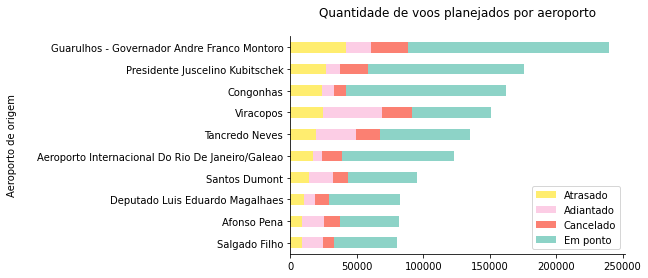

In [30]:
situacao_por_aeroporto_origem.tail(10).plot(kind='barh', stacked=True, colormap='Set3_r')
plt.title('Quantidade de voos planejados por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [31]:
#Ordenando os 10 maiores aeroportos por taxa de voos atrasados 
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem.tail(10).stack().groupby(level=0).apply(lambda x: 100*x / x.sum()).unstack()
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem_porcentagem.sort_values(by='Atrasado')

In [32]:
situacao_por_aeroporto_origem_porcentagem = situacao_por_aeroporto_origem_porcentagem[['Atrasado','Adiantado','Cancelado','Em ponto']]

In [33]:
situacao_por_aeroporto_origem_porcentagem

Situacao.Voo,Atrasado,Adiantado,Cancelado,Em ponto
Aeroporto.Origem,,,,
Salgado Filho,10.758759,19.505402,10.521451,59.214388
Afonso Pena,11.168523,19.771817,14.571729,54.487931
Deputado Luis Eduardo Magalhaes,12.235923,10.492620,13.035291,64.236166
Aeroporto Internacional Do Rio De Janeiro/Galeao,13.937070,5.103099,12.236578,68.723252
Tancredo Neves,14.164335,22.588527,13.239387,50.007751
Congonhas,14.876680,5.574827,5.450983,74.097510
Santos Dumont,14.902022,18.366342,12.521220,54.210416
Presidente Juscelino Kubitschek,15.159936,6.272411,11.747558,66.820096
Viracopos,16.490154,29.032130,15.302588,39.175128


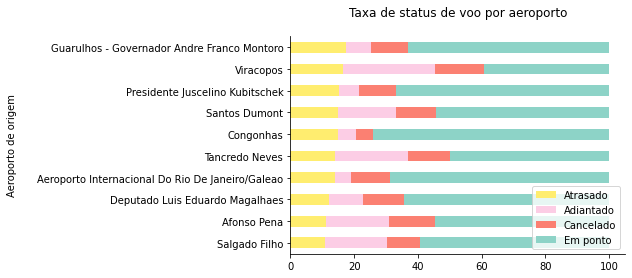

In [34]:
situacao_por_aeroporto_origem_porcentagem.plot(kind='barh', stacked=True, title='TOP 10 aeroportos por voos atrasados', colormap='Set3_r')
plt.title('Taxa de status de voo por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [35]:
#A partir deste resultado serão escolhidos 3 aeroportos com taxas de atraso parecidas para averiguar se os fatores que interferem on atraso são os mesmos
#Aeroportos escolhidos: Juscelino Kubitscheck (BSB, 15.16%), Santos Dumont (SDU, 14.90%) e Congonhas (CGH, 14.88%)

In [36]:
#filtrando apenas os voos com atrasos positivos
voos_brasil_atrasados = voos_brasil[voos_brasil['Situacao.Voo'].isin(['Atrasado'])]

In [37]:
voos_brasil_atrasados['Partida.Atraso'] = voos_brasil_atrasados['Partida.Real'] - voos_brasil_atrasados['Partida.Prevista']
voos_brasil_atrasados['Partida.Atraso'] = voos_brasil_atrasados['Partida.Atraso'].dt.seconds/60
voos_brasil_atrasados = voos_brasil_atrasados[voos_brasil_atrasados['Partida.Atraso'] > 0]

In [38]:
voos_brasil_atrasados.shape

(290516, 30)

In [39]:
#Selecionando os 3 aeroportos escolhidos
aeroportos_interesse = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'].isin(['Presidente Juscelino Kubitschek', 'Santos Dumont', 'Congonhas'])]

In [40]:
#Quantidade de voos atrasados por aeroporto
aeroportos_interesse.groupby('Aeroporto.Origem')['Companhia.Aerea'].value_counts().unstack()

Companhia.Aerea,AVIANCA BRASIL,AZUL,GOL,TAM
Aeroporto.Origem,,,,
Congonhas,3286,1434,12641,6782
Presidente Juscelino Kubitschek,4003,1381,8839,12453
Santos Dumont,2493,5772,5081,872


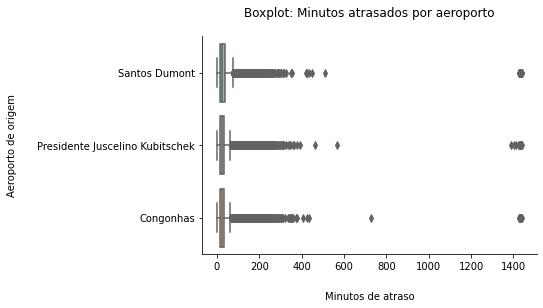

In [41]:
#Detectando outliers atraves de boxplot
sns.boxplot(x='Partida.Atraso', y='Aeroporto.Origem', data=aeroportos_interesse, palette="Accent")
plt.title('Boxplot: Minutos atrasados por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Minutos de atraso', labelpad=20)
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.show()

In [42]:
#Separando os 3 aeroportos para obter estatisticas individuais
bsb = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Presidente Juscelino Kubitschek']
sdu = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Santos Dumont']
cgh = voos_brasil_atrasados[voos_brasil_atrasados['Aeroporto.Origem'] == 'Congonhas']

In [43]:
box_stats_bsb = boxplot_stats(bsb['Partida.Atraso'])
box_stats_sdu = boxplot_stats(sdu['Partida.Atraso'])
box_stats_cgh = boxplot_stats(cgh['Partida.Atraso'])

In [44]:
#Mantendo apenas observações dentro de +- 1.5*IQR (critério de outlier de boxplot)
bsb = bsb[bsb['Partida.Atraso'] < box_stats_bsb[0]['q3']+1.5*box_stats_bsb[0]['iqr']]
sdu = sdu[sdu['Partida.Atraso'] < box_stats_sdu[0]['q3']+1.5*box_stats_sdu[0]['iqr']]
cgh = cgh[cgh['Partida.Atraso'] < box_stats_cgh[0]['q3']+1.5*box_stats_cgh[0]['iqr']]

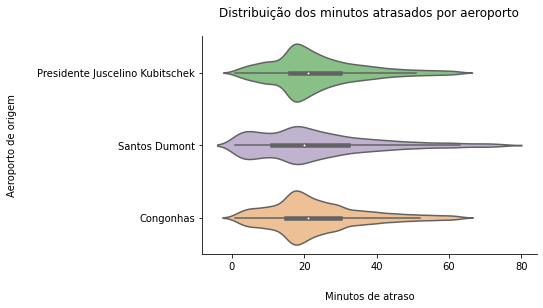

In [45]:
#Distribuição das observações após tratamento para cada aeroporto
aeroportos_interesse = aeroportos_interesse.loc[bsb.index.to_list() + sdu.index.to_list() + cgh.index.to_list()]
sns.violinplot(x='Partida.Atraso', y='Aeroporto.Origem', data=aeroportos_interesse, palette="Accent")
plt.title('Distribuição dos minutos atrasados por aeroporto', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Minutos de atraso', labelpad=20)
plt.ylabel('Aeroporto de origem', labelpad=20)
plt.show()

In [46]:
aeroportos_interesse = aeroportos_interesse.rename(columns=({'Companhia.Aerea': 'CiaAerea',
                                                             'Codigo.Justificativa': 'Justificativa', 
                                                             'Aeroporto.Destino': 'Destino',
                                                             'Aeroporto.Origem': 'Origem',
                                                             'Partida.Prevista.Dia.Semana':'DiaSemana',
                                                             'Partida.Atraso': 'Atraso'}))

In [47]:
#Começando a análise no aeroporto de brasília Juscelino Kubitschek
voos_bsb = aeroportos_interesse[aeroportos_interesse['Origem'] == 'Presidente Juscelino Kubitschek']

In [48]:
voos_bsb['Atraso'].describe()

count    24399.000000
mean        23.560228
std         12.697627
min          1.000000
25%         16.000000
50%         21.000000
75%         30.000000
max         63.000000
Name: Atraso, dtype: float64

In [49]:
coordenadas_destinos_bsb = pd.DataFrame()
coordenadas_destinos_bsb['Aeroporto'] = voos_bsb['Destino'].unique()
coordenadas_destinos_bsb['Longitude'] = voos_bsb['LongDest'].unique()
coordenadas_destinos_bsb['Latitude'] = voos_bsb['LatDest'].unique()
coordenadas_destinos_bsb = coordenadas_destinos_bsb.set_index('Aeroporto')

In [50]:
voos_por_destino_bsb = pd.DataFrame(data = voos_bsb.groupby(['Destino'])['Voos'].count())

In [51]:
df_plot_bsb = pd.concat([coordenadas_destinos_bsb,voos_por_destino_bsb], axis=1)
df_plot_bsb['ln(Qtd_voos)'] = np.log(df_plot_bsb['Voos'])
df_plot_bsb.sort_values(by='Voos', inplace=True)

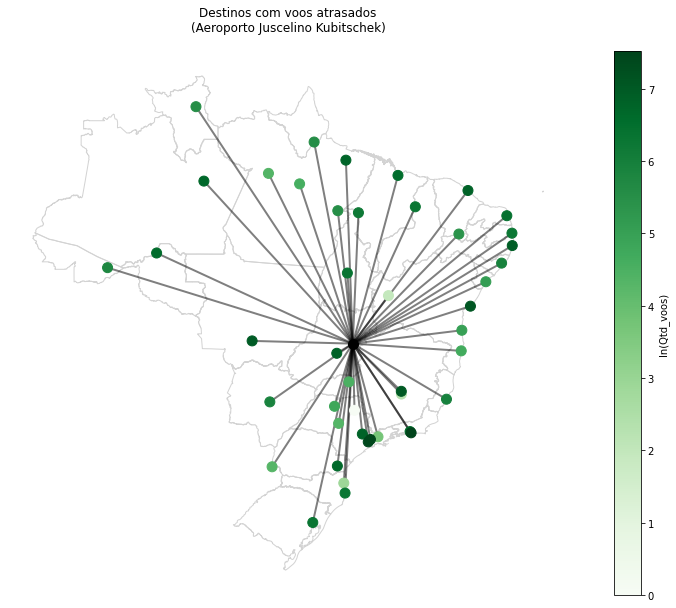

In [52]:
fig,ax = plt.subplots(figsize=(16,10))
mapa_brasil.plot(ax=ax, fc='None', ec='lightgray')
for i in df_plot_bsb.index:
  ax.plot([voos_bsb['LongOrig'].unique(),df_plot_bsb['Longitude'][i]],
          [voos_bsb['LatOrig'].unique(),df_plot_bsb['Latitude'][i]],
          color='black', lw=2, alpha=0.5, zorder=1)
ax.scatter(voos_bsb['LongOrig'].unique(), voos_bsb['LatOrig'].unique(), c='Black', zorder=2, s=100)
df_plot_bsb.plot(x='Longitude', y='Latitude', kind='scatter', s=100, ax=ax, zorder=2, c='ln(Qtd_voos)', cmap='Greens')
plt.title('Destinos com voos atrasados\n(Aeroporto Juscelino Kubitschek)', pad=20, fontsize=12, color='black')
sns.despine(bottom=True, left=True)
plt.ylabel(None)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel(None)
plt.show()

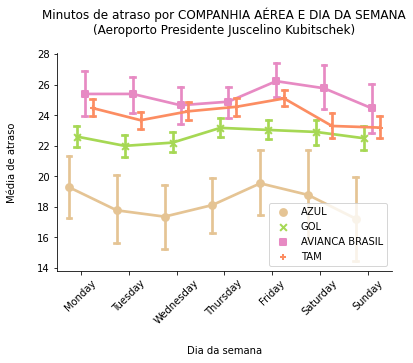

In [53]:
#Média de atraso por dia da semana e por companhia aerea com intervalo de confiança de 95%
sns.pointplot(x='DiaSemana', y='Atraso', data=voos_bsb, hue='CiaAerea', palette='Set2_r',
              ci=95, capsize=.1, markers=["o", "x", "s", "+"], dodge=0.5, order=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Minutos de atraso por COMPANHIA AÉREA E DIA DA SEMANA\n(Aeroporto Presidente Juscelino Kubitschek)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dia da semana', labelpad=20)
plt.ylabel('Média de atraso', labelpad=20)
plt.legend()
plt.show()

In [54]:
#2 way anova
model_bsb = ols('Atraso ~ C(DiaSemana) + C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_bsb).fit()
sm.stats.anova_lm(model_bsb, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),5.177050e+03,6.0,5.433163,1.262926e-05
C(CiaAerea),5.560764e+04,3.0,116.717203,4.773108e-75
C(DiaSemana):C(CiaAerea),2.719580e+03,18.0,0.951373,5.145734e-01
Residual,3.870363e+06,24371.0,NaN,NaN


In [55]:
#Como a interação DiaSemana:CiaAerea deu não significativa, rodamos novamente o modelo reduzido
model_bsb = ols('Atraso ~ C(DiaSemana) + C(CiaAerea)', voos_bsb).fit()
sm.stats.anova_lm(model_bsb, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),5.177050e+03,6.0,5.433358,1.262266e-05
C(CiaAerea),5.560764e+04,3.0,116.721392,4.739422e-75
Residual,3.873082e+06,24389.0,NaN,NaN


In [56]:
#Diferença entre os pares de dia da semana (reject == True significa que tem diferença)
mc_dia_da_semana_bsb = sm.stats.multicomp.MultiComparison(voos_bsb['Atraso'], voos_bsb['DiaSemana']).tukeyhsd()
print(mc_dia_da_semana_bsb)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
  Friday    Monday  -0.5932 0.3292 -1.4108  0.2243  False
  Friday  Saturday  -0.8467 0.1537 -1.8393  0.1459  False
  Friday    Sunday  -1.4703  0.001 -2.4192 -0.5214   True
  Friday  Thursday  -0.5001 0.5052 -1.2924  0.2922  False
  Friday   Tuesday  -1.1784  0.001 -2.0209 -0.3358   True
  Friday Wednesday  -0.9823  0.008 -1.8057 -0.1588   True
  Monday  Saturday  -0.2535    0.9 -1.2753  0.7683  False
  Monday    Sunday  -0.8771 0.1142 -1.8565  0.1023  False
  Monday  Thursday   0.0932    0.9 -0.7354  0.9217  False
  Monday   Tuesday  -0.5851 0.4377 -1.4619  0.2916  False
  Monday Wednesday   -0.389 0.8137 -1.2474  0.4694  False
Saturday    Sunday  -0.6236 0.6423 -1.7532   0.506  False
Saturday  Thursday   0.3466    0.9  -0.655  1.3483  False
Saturday   Tuesday  -0.3317    0.9 -1.3735  0.7102  False
Saturday Wedne

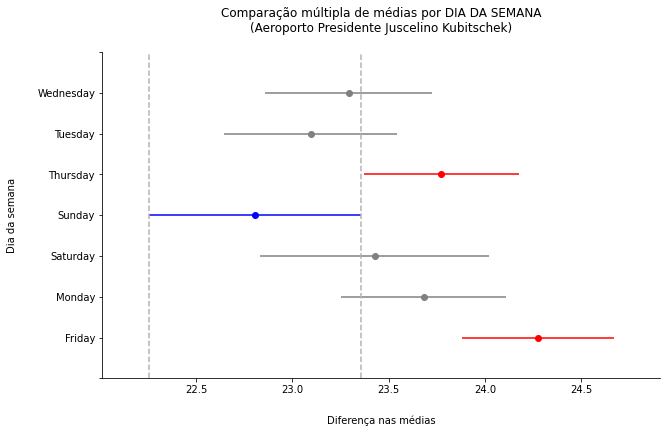

In [57]:
#A melhor média encontra-se destacada das demais
mc_dia_da_semana_bsb.plot_simultaneous(comparison_name = 'Sunday')
plt.title('Comparação múltipla de médias por DIA DA SEMANA\n(Aeroporto Presidente Juscelino Kubitschek)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Dia da semana', labelpad=20)
plt.show()

In [58]:
#Diferença entre os pares de Cia Aérea (reject == True tem diferença significativa)
mc_cia_aerea_bsb = sm.stats.multicomp.MultiComparison(voos_bsb['Atraso'], voos_bsb['CiaAerea']).tukeyhsd()
print(mc_cia_aerea_bsb)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
    group1     group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
AVIANCA BRASIL   AZUL  -6.9533 0.001 -8.0352 -5.8713   True
AVIANCA BRASIL    GOL  -2.6297 0.001   -3.29 -1.9695   True
AVIANCA BRASIL    TAM  -1.0506 0.001  -1.684 -0.4172   True
          AZUL    GOL   4.3235 0.001    3.33  5.3171   True
          AZUL    TAM   5.9027 0.001  4.9268  6.8785   True
           GOL    TAM   1.5791 0.001  1.1126  2.0457   True
-----------------------------------------------------------


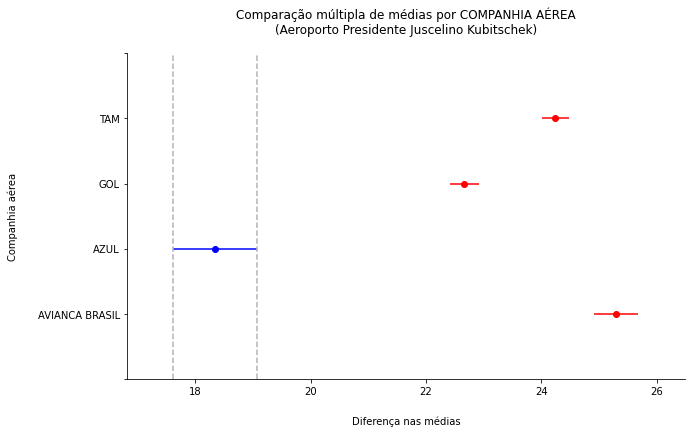

In [59]:
#A melhor média encontra-se destacada das demais
mc_cia_aerea_bsb.plot_simultaneous(comparison_name = 'AZUL')
plt.title('Comparação múltipla de médias por COMPANHIA AÉREA\n(Aeroporto Presidente Juscelino Kubitschek)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Companhia aérea', labelpad=20)
plt.show()

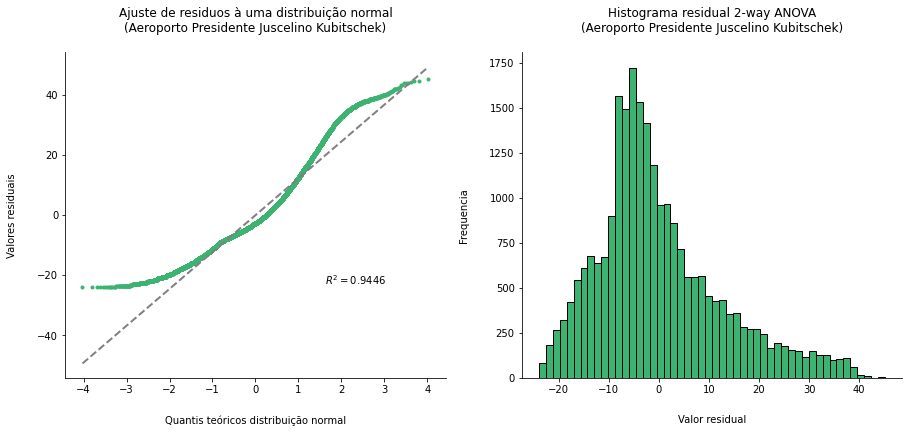

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
stats.probplot(model_bsb.resid, plot=ax1, rvalue=True)
ax1.set_title('Ajuste de residuos à uma distribuição normal\n(Aeroporto Presidente Juscelino Kubitschek)', pad=20, fontsize=12, color='black')
ax1.get_lines()[0].set_markerfacecolor('mediumseagreen')
ax1.get_lines()[0].set_markeredgecolor('mediumseagreen')
ax1.get_lines()[0].set_markersize(3)
ax1.get_lines()[1].set_linewidth(2)
ax1.get_lines()[1].set_linestyle('--')
ax1.get_lines()[1].set_color('gray')
ax1.set_xlabel('Quantis teóricos distribuição normal', labelpad=20)
ax1.set_ylabel('Valores residuais', labelpad=20)

ax2.hist(model_bsb.resid, ec='black', fc='mediumseagreen',bins=50)
ax2.set_title('Histograma residual 2-way ANOVA\n(Aeroporto Presidente Juscelino Kubitschek)', pad=20, fontsize=12, color='black')
ax2.set_xlabel('Valor residual', labelpad=20)
ax2.set_ylabel('Frequencia', labelpad=20)

sns.despine()
plt.show()

In [61]:
#Começando a análise do aeroporto carioca Santos Dumont
voos_sdu = aeroportos_interesse[aeroportos_interesse['Origem'] == 'Santos Dumont']

In [62]:
voos_sdu['Atraso'].describe()

count    12949.000000
mean        23.606611
std         16.747383
min          1.000000
25%         11.000000
50%         20.000000
75%         32.000000
max         75.000000
Name: Atraso, dtype: float64

In [63]:
coordenadas_destinos_sdu = pd.DataFrame()
coordenadas_destinos_sdu['Aeroporto'] = voos_sdu['Destino'].unique()
coordenadas_destinos_sdu['Longitude'] = voos_sdu['LongDest'].unique()
coordenadas_destinos_sdu['Latitude'] = voos_sdu['LatDest'].unique()
coordenadas_destinos_sdu = coordenadas_destinos_sdu.set_index('Aeroporto')

In [64]:
voos_por_destino_sdu = pd.DataFrame(data = voos_sdu.groupby(['Destino'])['Voos'].count())

In [65]:
df_plot_sdu = pd.concat([coordenadas_destinos_sdu,voos_por_destino_sdu], axis=1)
df_plot_sdu['ln(Qtd_voos)'] = np.log(df_plot_sdu['Voos'])
df_plot_sdu.sort_values(by='Voos', inplace=True)

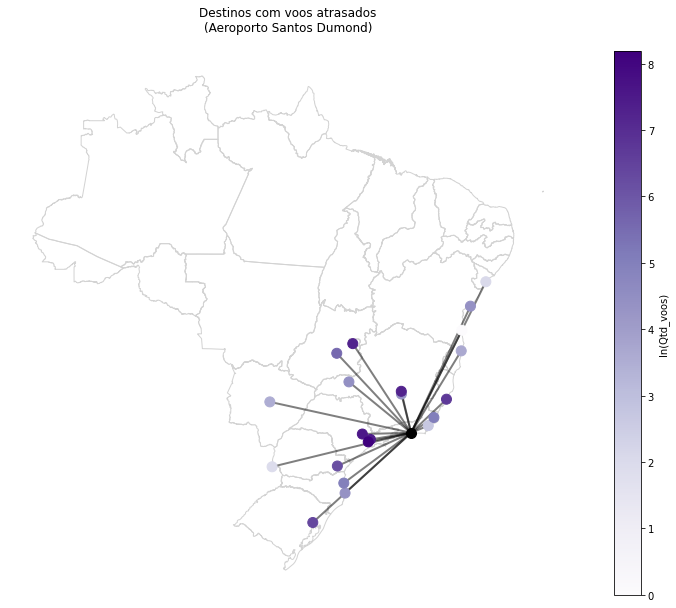

In [66]:
fig,ax = plt.subplots(figsize=(16,10))
mapa_brasil.plot(ax=ax, fc='None', ec='lightgray')
for i in df_plot_sdu.index:
  ax.plot([voos_sdu['LongOrig'].unique(),df_plot_sdu['Longitude'][i]],
          [voos_sdu['LatOrig'].unique(),df_plot_sdu['Latitude'][i]],
          color='black', lw=2, alpha=0.5, zorder=1)
ax.scatter(voos_sdu['LongOrig'].unique(), voos_sdu['LatOrig'].unique(), c='Black', zorder=2, s=100)
df_plot_sdu.plot(x='Longitude', y='Latitude', kind='scatter', s=100, ax=ax, zorder=2, c='ln(Qtd_voos)', cmap='Purples')
plt.title('Destinos com voos atrasados\n(Aeroporto Santos Dumond)', pad=20, fontsize=12, color='black')
sns.despine(bottom=True, left=True)
plt.ylabel(None)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel(None)
plt.show()

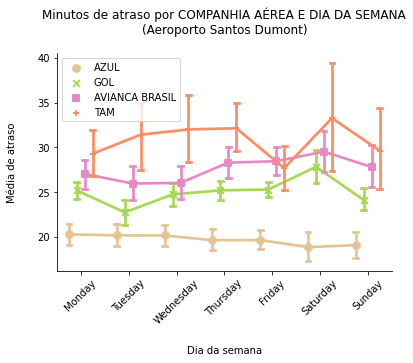

In [67]:
#Média de atraso por dia da semana e por companhia aerea com intervalo de confiança de 95%
sns.pointplot(x='DiaSemana', y='Atraso', data=voos_sdu, hue='CiaAerea', palette='Set2_r',
              ci=95, capsize=.1, markers=["o", "x", "s", "+"], dodge=0.5, order=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Minutos de atraso por COMPANHIA AÉREA E DIA DA SEMANA\n(Aeroporto Santos Dumont)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dia da semana', labelpad=20)
plt.ylabel('Média de atraso', labelpad=20)
plt.legend()
plt.show()

In [68]:
#2 way anova
model_sdu = ols('Atraso ~ C(DiaSemana) + C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_sdu).fit()
sm.stats.anova_lm(model_sdu, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),2.427460e+03,6.0,1.507016,1.713225e-01
C(CiaAerea),1.495727e+05,3.0,185.715484,6.598802e-118
C(DiaSemana):C(CiaAerea),8.910203e+03,18.0,1.843877,1.592695e-02
Residual,3.468799e+06,12921.0,NaN,NaN


In [69]:
#Dia da semana não é significativo no atraso, então rodamos o modelo reduzido
model_sdu = ols('Atraso ~ C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_sdu).fit()
sm.stats.anova_lm(model_sdu, typ=2)

,sum_sq,df,F,PR(>F)
C(CiaAerea),1.514512e+05,3.0,188.047864,2.321825e-119
C(DiaSemana):C(CiaAerea),1.133766e+04,24.0,1.759662,1.225849e-02
Residual,3.468799e+06,12921.0,NaN,NaN


In [70]:
#Diferenca entre os pares de Cia Aerea (reject == True tem diferença significativa)
mc_cia_aerea_sdu = sm.stats.multicomp.MultiComparison(voos_sdu['Atraso'], voos_sdu['CiaAerea']).tukeyhsd()
print(mc_cia_aerea_sdu)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
    group1     group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
AVIANCA BRASIL   AZUL  -7.7058 0.001 -8.7756  -6.636   True
AVIANCA BRASIL    GOL  -2.5661 0.001 -3.6541  -1.478   True
AVIANCA BRASIL    TAM   2.8543 0.001  1.0476  4.6609   True
          AZUL    GOL   5.1397 0.001  4.2973  5.9822   True
          AZUL    TAM  10.5601 0.001  8.8898 12.2304   True
           GOL    TAM   5.4203 0.001  3.7383  7.1024   True
-----------------------------------------------------------


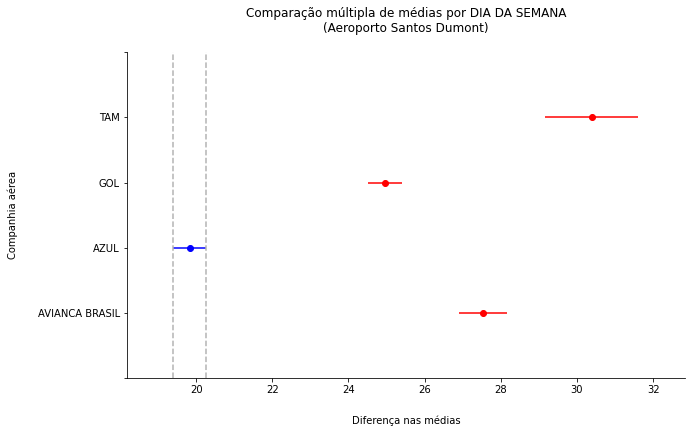

In [71]:
#A melhor média encontra-se destacada das demais
mc_cia_aerea_sdu.plot_simultaneous(comparison_name = 'AZUL')
plt.title('Comparação múltipla de médias por DIA DA SEMANA\n(Aeroporto Santos Dumont)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Companhia aérea', labelpad=20)
plt.show()

In [72]:
##Diferenca entre os pares de interação DiaSemana + CiaAerea (reject == True tem diferença significativa)
interaction_groups_sdu = voos_sdu['DiaSemana'] + ' & ' + voos_sdu['CiaAerea']
mc_interacao_cia_aerea_dia_da_semana_sdu = sm.stats.multicomp.MultiComparison(voos_sdu['Atraso'], interaction_groups_sdu).tukeyhsd()
print(mc_interacao_cia_aerea_dia_da_semana_sdu)

                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
          group1                     group2           meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------
   Friday & AVIANCA BRASIL              Friday & AZUL  -8.7852  0.001 -12.2318 -5.3386   True
   Friday & AVIANCA BRASIL               Friday & GOL  -3.1595 0.1048  -6.5291  0.2101  False
   Friday & AVIANCA BRASIL               Friday & TAM  -0.7673    0.9  -6.6041  5.0694  False
   Friday & AVIANCA BRASIL    Monday & AVIANCA BRASIL  -1.4236    0.9  -5.7601   2.913  False
   Friday & AVIANCA BRASIL              Monday & AZUL  -8.1506  0.001 -11.6002  -4.701   True
   Friday & AVIANCA BRASIL               Monday & GOL  -3.2573 0.0929  -6.6938  0.1793  False
   Friday & AVIANCA BRASIL               Monday & TAM   0.8503    0.9  -4.7036  6.4042  False
   Friday & AVIANCA BRASIL  Saturday & AVIANCA BRASIL   1.07

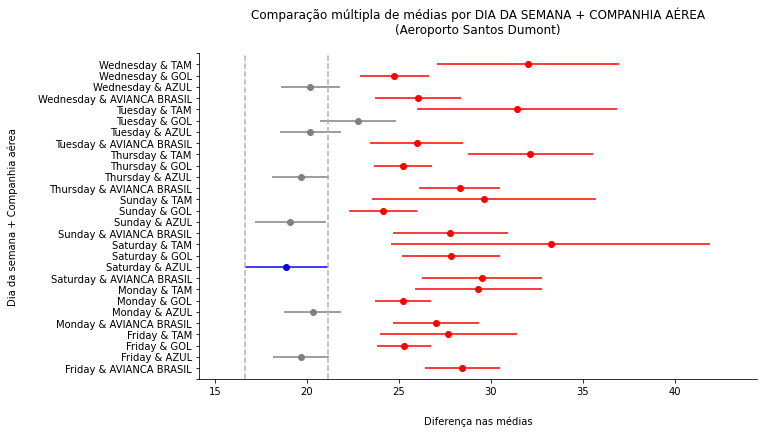

In [73]:
#A melhor média encontra-se destacada das demais
mc_interacao_cia_aerea_dia_da_semana_sdu.plot_simultaneous(comparison_name='Saturday & AZUL')
plt.title('Comparação múltipla de médias por DIA DA SEMANA + COMPANHIA AÉREA\n(Aeroporto Santos Dumont)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Dia da semana + Companhia aérea', labelpad=20)
plt.show()

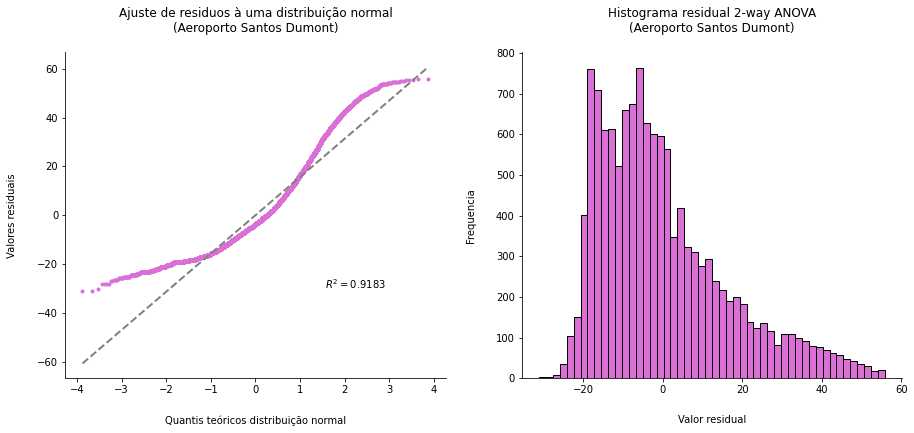

In [74]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
stats.probplot(model_sdu.resid, plot=ax1, rvalue=True)
ax1.set_title('Ajuste de residuos à uma distribuição normal\n(Aeroporto Santos Dumont)', pad=20, fontsize=12, color='black')
ax1.get_lines()[0].set_markerfacecolor('orchid')
ax1.get_lines()[0].set_markeredgecolor('orchid')
ax1.get_lines()[0].set_markersize(3)
ax1.get_lines()[1].set_linewidth(2)
ax1.get_lines()[1].set_linestyle('--')
ax1.get_lines()[1].set_color('gray')
ax1.set_xlabel('Quantis teóricos distribuição normal', labelpad=20)
ax1.set_ylabel('Valores residuais', labelpad=20)

ax2.hist(model_sdu.resid, ec='black', fc='orchid',bins=50)
ax2.set_title('Histograma residual 2-way ANOVA\n(Aeroporto Santos Dumont)', pad=20, fontsize=12, color='black')
ax2.set_xlabel('Valor residual', labelpad=20)
ax2.set_ylabel('Frequencia', labelpad=20)

sns.despine()
plt.show()

In [75]:
#Começando a análise do aeroporto carioca Santos Dumont
voos_cgh = aeroportos_interesse[aeroportos_interesse['Origem'] == 'Congonhas']

In [76]:
voos_cgh['Atraso'].describe()

count    21847.000000
mean        23.474390
std         13.188194
min          1.000000
25%         15.000000
50%         21.000000
75%         30.000000
max         63.000000
Name: Atraso, dtype: float64

In [77]:
coordenadas_destinos_cgh = pd.DataFrame()
coordenadas_destinos_cgh['Aeroporto'] = voos_cgh['Destino'].unique()
coordenadas_destinos_cgh['Longitude'] = voos_cgh['LongDest'].unique()
coordenadas_destinos_cgh['Latitude'] = voos_cgh['LatDest'].unique()
coordenadas_destinos_cgh = coordenadas_destinos_cgh.set_index('Aeroporto')

In [78]:
voos_por_destino_cgh = pd.DataFrame(data = voos_cgh.groupby(['Destino'])['Voos'].count())

In [79]:
df_plot_cgh = pd.concat([coordenadas_destinos_cgh,voos_por_destino_cgh], axis=1)
df_plot_cgh['ln(Qtd_voos)'] = np.log(df_plot_cgh['Voos'])
df_plot_cgh.sort_values(by='Voos', inplace=True)

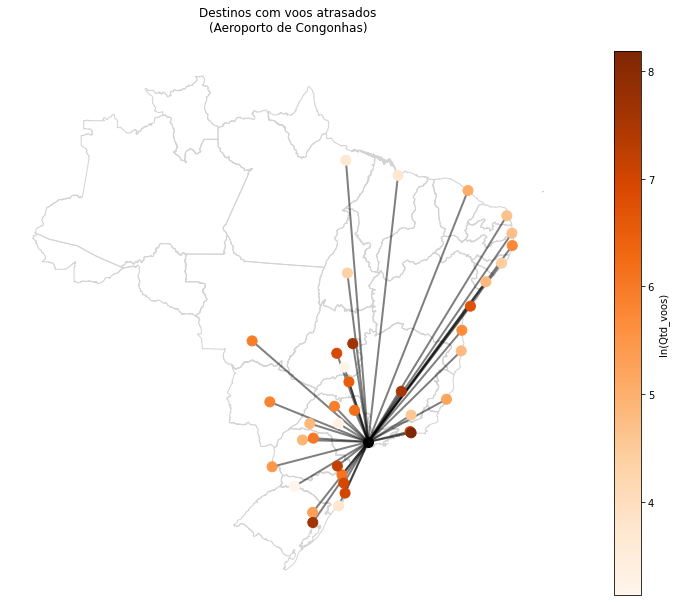

In [80]:
fig,ax = plt.subplots(figsize=(16,10))
mapa_brasil.plot(ax=ax, fc='None', ec='lightgray')
for i in df_plot_cgh.index:
  ax.plot([voos_cgh['LongOrig'].unique(),df_plot_cgh['Longitude'][i]],
          [voos_cgh['LatOrig'].unique(),df_plot_cgh['Latitude'][i]],
          color='black', lw=2, alpha=0.5, zorder=1)
ax.scatter(voos_cgh['LongOrig'].unique(), voos_cgh['LatOrig'].unique(), c='Black', zorder=2, s=100)
df_plot_cgh.plot(x='Longitude', y='Latitude', kind='scatter', s=100, ax=ax, zorder=2, c='ln(Qtd_voos)', cmap='Oranges')
plt.title('Destinos com voos atrasados\n(Aeroporto de Congonhas)', pad=20, fontsize=12, color='black')
sns.despine(bottom=True, left=True)
plt.ylabel(None)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel(None)
plt.show()

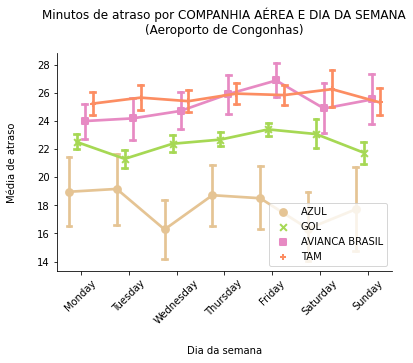

In [81]:
#Média de atraso por dia da semana e por companhia aerea com intervalo de confiança de 95%
sns.pointplot(x='DiaSemana', y='Atraso', data=voos_cgh, hue='CiaAerea', palette='Set2_r', title='Atraso por CiaAerea e DiaSemana',
              ci=95, capsize=.1, markers=["o", "x", "s", "+"], dodge=0.5, order=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Minutos de atraso por COMPANHIA AÉREA E DIA DA SEMANA\n(Aeroporto de Congonhas)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xticks(rotation=45)
plt.xlabel('Dia da semana', labelpad=20)
plt.ylabel('Média de atraso', labelpad=20)
plt.legend(loc='lower right')
plt.show()

In [82]:
#2 way anova
model_cgh = ols('Atraso ~ C(DiaSemana) + C(CiaAerea) + C(DiaSemana):C(CiaAerea)', voos_cgh).fit()
sm.stats.anova_lm(model_cgh, typ=2)

,sum_sq,df,F,PR(>F)
C(DiaSemana),5.456521e+03,6.0,5.357067,1.546404e-05
C(CiaAerea),8.558674e+04,3.0,168.053573,1.041581e-107
C(DiaSemana):C(CiaAerea),4.834636e+03,18.0,1.582172,5.524041e-02
Residual,3.704012e+06,21819.0,NaN,NaN


In [83]:
#Diferenca entre os pares de DiaSemana (reject == True tem diferença significativa)
mc_dia_da_semana_cgh = sm.stats.multicomp.MultiComparison(voos_cgh['Atraso'], voos_cgh['DiaSemana']).tukeyhsd()
print(mc_dia_da_semana_cgh)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
  Friday    Monday  -1.0479 0.0059  -1.906 -0.1898   True
  Friday  Saturday  -0.7174 0.5398 -1.8912  0.4564  False
  Friday    Sunday  -0.7929 0.3146 -1.8726  0.2868  False
  Friday  Thursday  -0.5006 0.5542  -1.331  0.3298  False
  Friday   Tuesday  -1.5053  0.001   -2.43 -0.5806   True
  Friday Wednesday  -1.0815 0.0053 -1.9601 -0.2029   True
  Monday  Saturday   0.3305    0.9 -0.8824  1.5434  False
  Monday    Sunday   0.2551    0.9 -0.8671  1.3772  False
  Monday  Thursday   0.5473 0.5271 -0.3375  1.4321  False
  Monday   Tuesday  -0.4574 0.7852 -1.4312  0.5165  False
  Monday Wednesday  -0.0336    0.9 -0.9638  0.8967  False
Saturday    Sunday  -0.0755    0.9 -1.4541  1.3032  False
Saturday  Thursday   0.2168    0.9 -0.9767  1.4103  False
Saturday   Tuesday  -0.7879 0.5161 -2.0488   0.473  False
Saturday Wedne

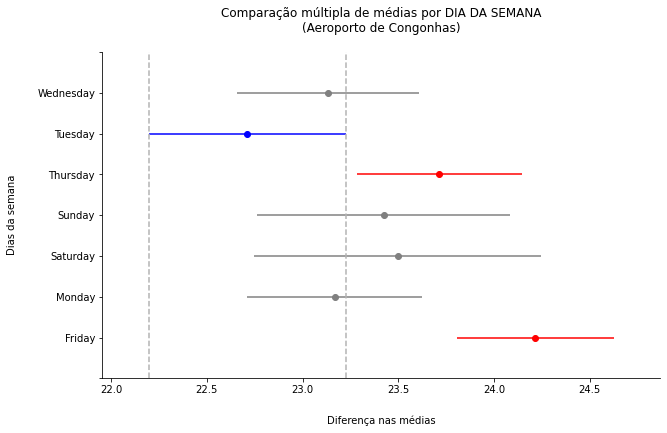

In [84]:
#A melhor média encontra-se destacada das demais
mc_dia_da_semana_cgh.plot_simultaneous(comparison_name='Tuesday')
plt.title('Comparação múltipla de médias por DIA DA SEMANA\n(Aeroporto de Congonhas)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Dias da semana', labelpad=20)
plt.show()

In [85]:
#Diferenca entre os pares de Cia Aerea (reject == True tem diferença significativa)
mc_cia_aerea_cgh = sm.stats.multicomp.MultiComparison(voos_cgh['Atraso'], voos_cgh['CiaAerea']).tukeyhsd()
print(mc_cia_aerea_cgh)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
AVIANCA BRASIL   AZUL  -7.3003  0.001 -8.4332 -6.1674   True
AVIANCA BRASIL    GOL   -2.731  0.001 -3.4318 -2.0302   True
AVIANCA BRASIL    TAM   0.3608 0.6054 -0.4046  1.1262  False
          AZUL    GOL   4.5693  0.001  3.5782  5.5604   True
          AZUL    TAM   7.6611  0.001  6.6233  8.6989   True
           GOL    TAM   3.0918  0.001  2.5584  3.6252   True
------------------------------------------------------------


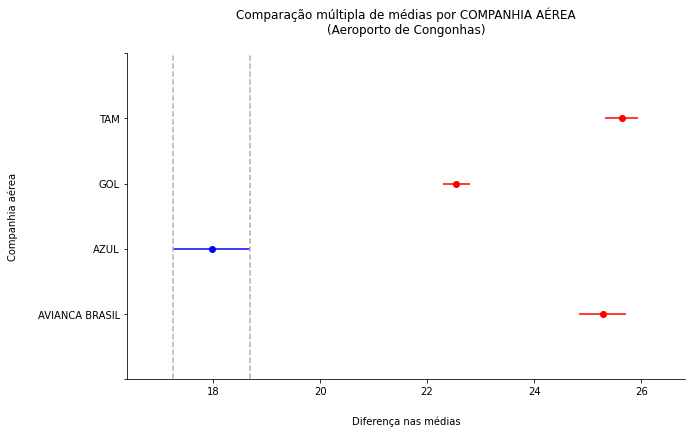

In [86]:
#A melhor média encontra-se destacada das demais
mc_cia_aerea_cgh.plot_simultaneous(comparison_name='AZUL')
plt.title('Comparação múltipla de médias por COMPANHIA AÉREA\n(Aeroporto de Congonhas)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Companhia aérea', labelpad=20)
plt.show()

In [87]:
#Diferenca entre os pares de interação Dia Semana + Cia Aerea (reject == True tem diferença significativa)
interaction_groups_cgh = voos_cgh['DiaSemana'] + ' & ' + voos_cgh['CiaAerea']
mc_interacao_cia_aerea_dia_da_semana_cgh = sm.stats.multicomp.MultiComparison(voos_cgh['Atraso'], interaction_groups_cgh).tukeyhsd()
print(mc_interacao_cia_aerea_dia_da_semana_cgh)

                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
          group1                     group2           meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------
   Friday & AVIANCA BRASIL              Friday & AZUL  -8.3677  0.001 -12.2548 -4.4806   True
   Friday & AVIANCA BRASIL               Friday & GOL  -3.4765  0.001  -5.6819 -1.2712   True
   Friday & AVIANCA BRASIL               Friday & TAM  -1.0379    0.9  -3.4875  1.4118  False
   Friday & AVIANCA BRASIL    Monday & AVIANCA BRASIL  -2.8838    0.1  -5.9464  0.1787  False
   Friday & AVIANCA BRASIL              Monday & AZUL  -7.9085  0.001 -12.0169 -3.8002   True
   Friday & AVIANCA BRASIL               Monday & GOL  -4.3738  0.001  -6.6333 -2.1144   True
   Friday & AVIANCA BRASIL               Monday & TAM  -1.6416 0.8005  -4.2163   0.933  False
   Friday & AVIANCA BRASIL  Saturday & AVIANCA BRASIL  -1.98

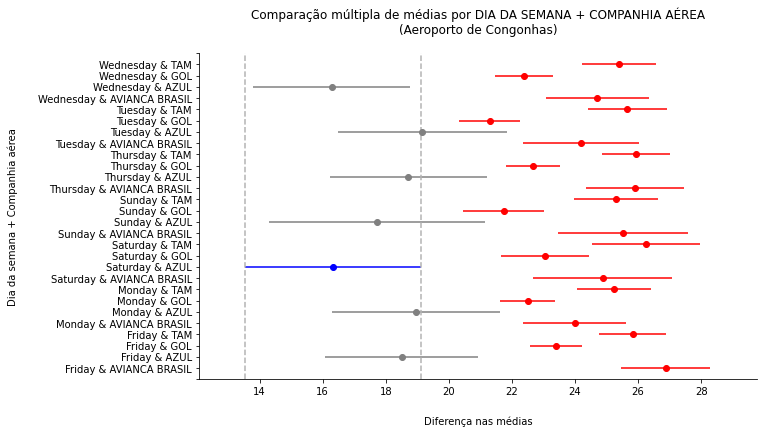

In [88]:
#A melhor média encontra-se destacada das demais
mc_interacao_cia_aerea_dia_da_semana_cgh.plot_simultaneous(comparison_name='Saturday & AZUL')
plt.title('Comparação múltipla de médias por DIA DA SEMANA + COMPANHIA AÉREA\n(Aeroporto de Congonhas)', pad=20, fontsize=12, color='black')
sns.despine()
plt.xlabel('Diferença nas médias', labelpad=20)
plt.ylabel('Dia da semana + Companhia aérea', labelpad=20)
plt.show()

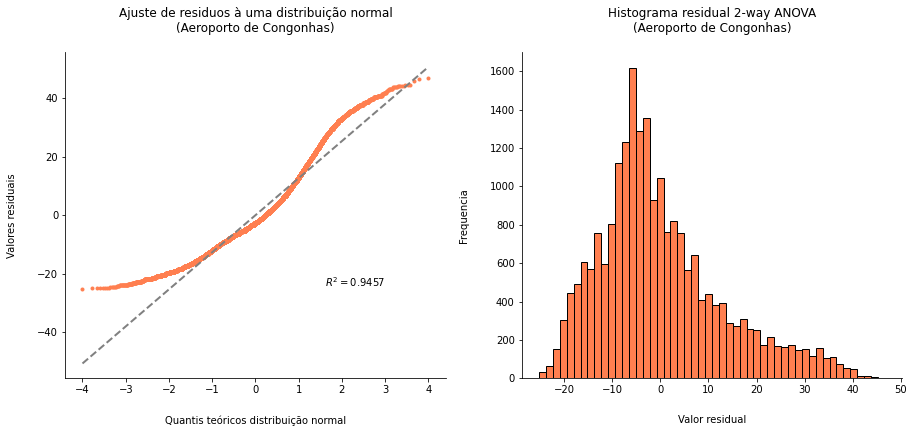

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
stats.probplot(model_cgh.resid, plot=ax1, rvalue=True)
ax1.set_title('Ajuste de residuos à uma distribuição normal\n(Aeroporto de Congonhas)', pad=20, fontsize=12, color='black')
ax1.get_lines()[0].set_markerfacecolor('coral')
ax1.get_lines()[0].set_markeredgecolor('coral')
ax1.get_lines()[0].set_markersize(3)
ax1.get_lines()[1].set_linewidth(2)
ax1.get_lines()[1].set_linestyle('--')
ax1.get_lines()[1].set_color('gray')
ax1.set_xlabel('Quantis teóricos distribuição normal', labelpad=20)
ax1.set_ylabel('Valores residuais', labelpad=20)

ax2.hist(model_cgh.resid, ec='black', fc='coral',bins=50)
ax2.set_title('Histograma residual 2-way ANOVA\n(Aeroporto de Congonhas)', pad=20, fontsize=12, color='black')
ax2.set_xlabel('Valor residual', labelpad=20)
ax2.set_ylabel('Frequencia', labelpad=20)

sns.despine()
plt.show()